In [ ]:
!pip install deeplake

In [ ]:
!pip install transformers

In [ ]:
!pip install nltk

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F

import deeplake
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Preprocess Data



In [ ]:
ds = deeplake.load('hub://activeloop/flickr30k')

-

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



-

hub://activeloop/flickr30k loaded successfully.



In [ ]:
images = ds.image
caption_list_1 = ds.caption_0
caption_list_2 = ds.caption_1
caption_list_3 = ds.caption_2
caption_list_4 = ds.caption_3
caption_list_5 = ds.caption_4
all_captions = [caption_list_1, caption_list_2, caption_list_3, caption_list_4, caption_list_5]

In [ ]:
print(ds.image.shape)  # Image shape
print(ds.caption_0.shape)  # Caption shape
print(len(images))

(31783, None, None, 3)
(31783, 1)
31783


['Crowds of people are walking are multicolored tents and flags that are put up outside in a cement lot as a big city looms in the distance .']


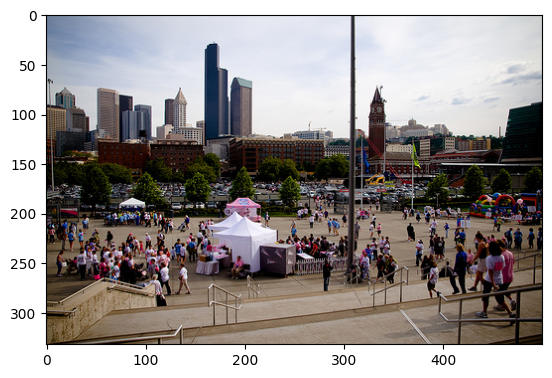

In [ ]:
#example image, caption
image_1 = images[0].numpy()
plt.imshow(image_1)
print(caption_list_1[0].numpy())

### Image Processing

In [ ]:
image = ds.image
print(image_1.shape) # 332, 500, 3

(332, 500, 3)


In [ ]:
img_size = 256

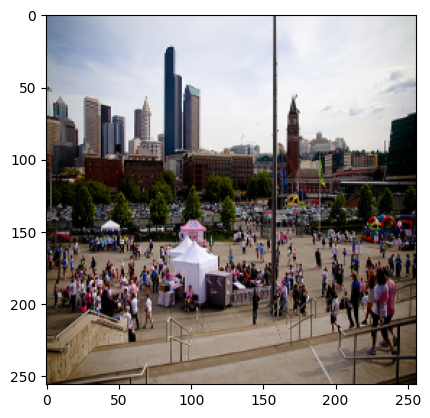

In [ ]:
def preprocess_image(image):
    image = tf.image.resize(image, (img_size, img_size))
    image = (image / 255.0)  # Normalize image to [0,1] range
    return image

image_1_preprocessed = preprocess_image(image_1)
plt.imshow(image_1_preprocessed.numpy())
# processed_images = [preprocess_image(img.numpy()) for img in image_list]

### Caption Processing

*Currently only using Caption 1 to generate. Future Step : Average tokenization of all captions*

Tokenization : Convert each text into sequences of integers.

Key Ideas involved:
1. Padding - pad caption with end-of-sequence token to ensure all captions have the same length (max_length)
2. truncation - truncate a caption into a shorter caption to match the max_length
3. Vocabulary - dictionary for word-to-index mapping
4. Attention mask - 1 if it is actual word, 0 if it is padded token


**Questions? Do we use tf's tokenizer or word2vec or BERT tokenizer?  z**

TensorFlow's tokenizer converts text to sequences of integers. These tokens are just a placeholders for words, with no inherent meaning or semantic relationship between them.

Word2Vec tokenizer creates word embeddings where semantically similar words are close together in the embedding space.

BERT tokenizer leverage pretrained BERT models to generate embeddings

We used BERT tokenizer as when used with pretrained BERT model, it helps to create contextualized word representations

In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
max_length = 20 # max length of caption

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
caption_list_1[1].numpy()[0]

'Two women in a light blue and a dark blue jacket walking in a crosswalk and a fake giant rat is on the sidewalk behind them .'

In [ ]:
def tokenize_and_embed(caption_texts):
    tokenized = tokenizer(
        caption_texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    input_ids, attention_mask = tokenized['input_ids'], tokenized['attention_mask']
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    return outputs.last_hidden_state  # Shape: (batch_size, max_len, hidden_dim) = (1, 20, 768)

def process_images(n):
    all_embeddings = []
    # for each image
    for i in range(n):
      caption = caption_list_1[i].numpy()[0]
      embedding = tokenize_and_embed([caption])
      all_embeddings.append(embedding)

    return tf.stack(all_embeddings)  # Stack all embeddings


Shape of image embeddings: (10, 1, 768)


In [ ]:
import nltk
nltk.download('punkt')
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the captions
tokens = []
for caption in caption_list_1:
    tokens.extend(word_tokenize(caption.numpy()[0].lower()))  # Convert to lowercase for consistency

# Count unique tokens
vocab_counter = Counter(tokens)
vocab_size = len(vocab_counter)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Example: Process the first 10 images
# n_images = 10
captions= process_images(len(images))

print(f"Shape of image embeddings: {captions.shape}") # 10, 1, 768

Shape of image embeddings: (10, 1, 768)


#### Use all 5 captions and average them


In [ ]:

# def tokenize_and_embed(caption_texts):
#     tokenized = tokenizer(
#         caption_texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf'
#     )
#     input_ids, attention_mask = tokenized['input_ids'], tokenized['attention_mask']
#     outputs = bert_model(input_ids, attention_mask=attention_mask)
#     return outputs.last_hidden_state  # Shape: (batch_size, max_len, hidden_dim)

# # Tokenize all captions. For each image, take average of tokenized
# def ave_caption(captions_for_one_image):
#     caption_embeddings = []

#     for caption in captions_for_one_image:
#         embedding = tokenize_and_embed([caption])
#         caption_embeddings.append(embedding)

#     caption_embeddings = tf.stack(caption_embeddings)  # Shape: (5, batch_size, max_len, hidden_dim)
#     avg_embedding = tf.reduce_mean(caption_embeddings, axis=0)  # Shape: (batch_size, max_len, hidden_dim)

#     return avg_embedding  # This is the averaged embedding for the image

# def process_all_images(n_images):
#     all_avg_embeddings = []

#     for i in range(n_images):
#         captions_for_image_i = [
#             caption_list_1[i].numpy()[0],
#             caption_list_2[i].numpy()[0],
#             caption_list_3[i].numpy()[0],
#             caption_list_4[i].numpy()[0],
#             caption_list_5[i].numpy()[0]
#         ]

#         # Get the averaged embedding for this image
#         avg_embedding = ave_caption(captions_for_image_i)
#         all_avg_embeddings.append(avg_embedding)

#     return tf.stack(all_avg_embeddings)  # Stack all averaged embeddings

# # Example: Process the first 10 images
# n_images = 10  # You can change this as needed
# image_embeddings = process_all_images(n_images)

# print(f"Shape of image embeddings: {image_embeddings.shape}")


KeyboardInterrupt: 

In [ ]:
caption_list_1 = ds.caption_0
caption_list_2 = ds.caption_1
caption_list_3 = ds.caption_2
caption_list_4 = ds.caption_3
caption_list_5 = ds.caption_4
freq = {}

def add_to_freq(caption_list, freq):
  for i in range(len(caption_list)):
    words_1 = caption_list[i].numpy()[0].split()
    for word in words_1:
      if word != '.':
        word = word.lower().strip(',')
        if len(word) > 0:
          if word in freq:
            freq[word] += 1
          else:
            freq[word] = 1

add_to_freq(caption_list_1, freq)
add_to_freq(caption_list_2, freq)
add_to_freq(caption_list_3, freq)
add_to_freq(caption_list_4, freq)
add_to_freq(caption_list_5, freq)

sorted_freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))
print(sorted_freq)

# Image Encoding

Used ResNet for CNN encoder. Built our own resnet

### Building own ResNet


In [ ]:
## Building ResNet
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the shortcut connection
        out = F.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example usage: Creating a ResNet with 18 layers
def ResNet18(num_classes=1000):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

# Instantiate the model
resnet18 = ResNet18(num_classes=embed_size)  # Change num_classes to your desired output size for image captioning


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = resnet18  # Use the custom ResNet model

    def forward(self, images):
        features = self.resnet(images)  # Get features from ResNet
        return features


In [ ]:
import torch
import torch.nn as nn

class LSTMDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(LSTMDecoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

        # Fully connected layer to output vocab size
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        # features: (batch_size, embed_size)
        # captions: (batch_size, max_length)

        # Get the embeddings for the captions
        embeddings = self.embedding(captions)  # (batch_size, max_length, embed_size)

        # Concatenate the image features with the embeddings
        # We need to repeat the image features for each time step (max_length)
        features = features.unsqueeze(1)  # (batch_size, 1, embed_size)
        features = features.repeat(1, embeddings.size(1), 1)  # (batch_size, max_length, embed_size)

        # Combine image features and caption embeddings
        lstm_input = torch.cat((features, embeddings), dim=2)  # (batch_size, max_length, embed_size + embed_size)

        # Pass through the LSTM
        lstm_out, _ = self.lstm(lstm_input)  # (batch_size, max_length, hidden_size)

        # Output layer
        outputs = self.fc(lstm_out)  # (batch_size, max_length, vocab_size)

        return outputs

### With Pretrained ResNet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN_encoder(nn.Module):
    def __init__(self, embed_size):
        super(CNN_encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.dropout = nn.Dropout(0.5)

        for param in list(resnet.parameters())[:-10]:
          param.requires_grad=False

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        features = self.dropout(features)
        return features


# Example: Create the model
embed_size = 512  # Example embed size
model = CNN_encoder(embed_size=embed_size)
print(model)

# Caption Decoding

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load pre-trained ResNet50 model without the final fully connected layer
cnn_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Example function to extract features from an image
def extract_image_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # Extract features from the image
    features = cnn_model.predict(img)
    return features

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Add

# Model parameters
vocab_size = 5000        # Vocabulary size (from tokenizer)
embedding_dim = 512       # Dimension of word embeddings
units = 512               # LSTM units
max_length = 25           # Maximum caption length

# Define the image feature input (from CNN)
image_input = Input(shape=(2048,), name="image_input")
image_features = Dense(units, activation='relu')(image_input)  # Fully connected layer to initialize LSTM

# Define the caption input (sequences of tokens)
caption_input = Input(shape=(max_length,), name="caption_input")
# Embedding layer for the caption words
caption_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(caption_input)

from tensorflow.keras.layers import RepeatVector, Concatenate

# Repeat the image features (expand to the same number of time steps as the caption)
image_features_repeated = RepeatVector(max_length)(image_features)

# Concatenate image features with the embedded caption at each time step
lstm_input = Add()([image_features_repeated, caption_embedding])

# LSTM layer that takes the combined input
lstm_output = LSTM(units, return_sequences=True)(lstm_input)

# Output layer to predict the next word in the caption sequence
output = Dense(vocab_size, activation='softmax')(lstm_output)

# Create the model
decoder_model = Model(inputs=[image_input, caption_input], outputs=output)
decoder_model.summary()

In [ ]:
decoder_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

n = np.random.uniform(size = (10, 2048))
caption_input = np.random.randint(0, 5000, size = (10, 25))
output = np.random.randint(0, 5000, size = (10, 25))
# Train the model with the image features and the output caption sequences
decoder_model.fit([n, caption_input], output, epochs=10, batch_size=64)

In [ ]:
input = np.random.uniform(size = (1, 2048))
caption_input = np.random.randint(0, 5000, size = (1, 25))
out = decoder_model.predict([input, caption_input])

In [ ]:
def generate_caption(image_features, tokenizer, max_length):
    # Start with the <start> token
    caption = ['<start>']

    for _ in range(max_length):
        # Convert the current caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict the next word
        yhat = decoder_model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)  # Get the word with the highest probability

        # Convert the integer back to a word
        word = tokenizer.index_word[yhat]
        caption.append(word)

        # Stop if <end> token is predicted
        if word == '<end>':
            break

    return ' '.join(caption[1:-1])

# Training

# Evaluation